In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!mkdir celeba
!unzip "/content/drive/MyDrive/Courses/PML/img_align_celeba.zip" -d ./celeba/
!rm -r "/content/celeba/__MACOSX"

In [1]:
"""Utility functions for real NVP.
"""

import torch
import torch.nn.functional as F
import torch.distributions as distributions
import torch.utils.data as data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np

class DataInfo():
    def __init__(self, name, channel, size):
        """Instantiates a DataInfo.

        Args:
            name: name of dataset.
            channel: number of image channels.
            size: height and width of an image.
        """
        self.name = name
        self.channel = channel
        self.size = size

def load(dataset):
    """Load dataset.

    Args:
        dataset: name of dataset.
    Returns:
        a torch dataset and its associated information.
    """
    if dataset == 'cifar10':    # 3 x 32 x 32
        data_info = DataInfo(dataset, 3, 32)
        transform = transforms.Compose(
            [transforms.RandomHorizontalFlip(p=0.5), 
             transforms.ToTensor()])
        train_set = datasets.CIFAR10('../../data/CIFAR10', 
            train=True, download=True, transform=transform)
        [train_split, val_split] = data.random_split(train_set, [46000, 4000])

    elif dataset == 'celeba':   # 3 x 218 x 178
        data_info = DataInfo(dataset, 3, 64)
        def CelebACrop(images):
            return transforms.functional.crop(images, 40, 15, 148, 148)
        transform = transforms.Compose(
            [CelebACrop, 
             transforms.Resize(64), 
             transforms.RandomHorizontalFlip(p=0.5), 
             transforms.ToTensor()])
        train_set = datasets.ImageFolder('/content/celeba', 
            transform=transform)
        
        # print('len celeba dataset', len(train_set ))
        # raise "sajjad"
        [train_split, val_split] = data.random_split(train_set, [200000, 2599])

    elif dataset == 'imnet32':
        data_info = DataInfo(dataset, 3, 32)
        transform = transforms.Compose(
            [transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()])
        train_set = datasets.ImageFolder('../../data/ImageNet32/train', 
            transform=transform)
        [train_split, val_split] = data.random_split(train_set, [1250000, 31149])

    elif dataset == 'imnet64':
        data_info = DataInfo(dataset, 3, 64)
        transform = transforms.Compose(
            [transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()])
        train_set = datasets.ImageFolder('../../data/ImageNet64/train', 
            transform=transform)
        [train_split, val_split] = data.random_split(train_set, [1250000, 31149])

    return train_split, val_split, data_info

def logit_transform(x, constraint=0.9, reverse=False):
    '''Transforms data from [0, 1] into unbounded space.

    Restricts data into [0.05, 0.95].
    Calculates logit(alpha+(1-alpha)*x).

    Args:
        x: input tensor.
        constraint: data constraint before logit.
        reverse: True if transform data back to [0, 1].
    Returns:
        transformed tensor and log-determinant of Jacobian from the transform.
        (if reverse=True, no log-determinant is returned.)
    '''
    if reverse:
        x = 1. / (torch.exp(-x) + 1.)    # [0.05, 0.95]
        x *= 2.             # [0.1, 1.9]
        x -= 1.             # [-0.9, 0.9]
        x /= constraint     # [-1, 1]
        x += 1.             # [0, 2]
        x /= 2.             # [0, 1]
        return x, 0
    else:
        [B, C, H, W] = list(x.size())
        
        # dequantization
        noise = distributions.Uniform(0., 1.).sample((B, C, H, W))
        x = (x * 255. + noise) / 256.
        
        # restrict data
        x *= 2.             # [0, 2]
        x -= 1.             # [-1, 1]
        x *= constraint     # [-0.9, 0.9]
        x += 1.             # [0.1, 1.9]
        x /= 2.             # [0.05, 0.95]

        # logit data
        logit_x = torch.log(x) - torch.log(1. - x)

        # log-determinant of Jacobian from the transform
        pre_logit_scale = torch.tensor(
            np.log(constraint) - np.log(1. - constraint))
        log_diag_J = F.softplus(logit_x) + F.softplus(-logit_x) \
            - F.softplus(-pre_logit_scale)

        return logit_x, torch.sum(log_diag_J, dim=(1, 2, 3))

In [2]:
"""Utility classes for real NVP.
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class WeightNormConv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size, stride=1, padding=0, 
        bias=True, weight_norm=True, scale=False):
        """Intializes a Conv2d augmented with weight normalization.

        (See torch.nn.utils.weight_norm for detail.)

        Args:
            in_dim: number of input channels.
            out_dim: number of output channels.
            kernel_size: size of convolving kernel.
            stride: stride of convolution.
            padding: zero-padding added to both sides of input.
            bias: True if include learnable bias parameters, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
            scale: True if include magnitude parameters, False otherwise.
        """
        super(WeightNormConv2d, self).__init__()

        if weight_norm:
            self.conv = nn.utils.weight_norm(
                nn.Conv2d(in_dim, out_dim, kernel_size, 
                    stride=stride, padding=padding, bias=bias))
            if not scale:
                self.conv.weight_g.data = torch.ones_like(self.conv.weight_g.data)
                self.conv.weight_g.requires_grad = False    # freeze scaling
        else:
            self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, 
                stride=stride, padding=padding, bias=bias)

    def forward(self, x):
        """Forward pass.

        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        return self.conv(x)

class ResidualBlock(nn.Module):
    def __init__(self, dim, bottleneck, weight_norm):
        """Initializes a ResidualBlock.

        Args:
            dim: number of input and output features.
            bottleneck: True if use bottleneck, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
        """
        super(ResidualBlock, self).__init__()
        
        self.in_block = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU())
        if bottleneck:
            self.res_block = nn.Sequential(
                WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (1, 1), stride=1, padding=0, 
                    bias=True, weight_norm=weight_norm, scale=True))
        else:
            self.res_block = nn.Sequential(
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=False, weight_norm=weight_norm, scale=False),
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                    bias=True, weight_norm=weight_norm, scale=True))

    def forward(self, x):
        """Forward pass.

        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        return x + self.res_block(self.in_block(x))

class ResidualModule(nn.Module):
    def __init__(self, in_dim, dim, out_dim, 
        res_blocks, bottleneck, skip, weight_norm):
        """Initializes a ResidualModule.

        Args:
            in_dim: number of input features.
            dim: number of features in residual blocks.
            out_dim: number of output features.
            res_blocks: number of residual blocks to use.
            bottleneck: True if use bottleneck, False otherwise.
            skip: True if use skip architecture, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
        """
        super(ResidualModule, self).__init__()
        self.res_blocks = res_blocks
        self.skip = skip
        
        if res_blocks > 0:
            self.in_block = WeightNormConv2d(in_dim, dim, (3, 3), stride=1, 
                padding=1, bias=True, weight_norm=weight_norm, scale=False)
            self.core_block = nn.ModuleList(
                [ResidualBlock(dim, bottleneck, weight_norm) 
                for _ in range(res_blocks)])
            self.out_block = nn.Sequential(
                nn.BatchNorm2d(dim),
                nn.ReLU(),
                WeightNormConv2d(dim, out_dim, (1, 1), stride=1, padding=0, 
                    bias=True, weight_norm=weight_norm, scale=True))
        
            if skip:
                self.in_skip = WeightNormConv2d(dim, dim, (1, 1), stride=1, 
                    padding=0, bias=True, weight_norm=weight_norm, scale=True)
                self.core_skips = nn.ModuleList(
                    [WeightNormConv2d(
                        dim, dim, (1, 1), stride=1, padding=0, bias=True, 
                        weight_norm=weight_norm, scale=True) 
                    for _ in range(res_blocks)])
        else:
            if bottleneck:
                self.block = nn.Sequential(
                    WeightNormConv2d(in_dim, dim, (1, 1), stride=1, padding=0, 
                        bias=False, weight_norm=weight_norm, scale=False),
                    nn.BatchNorm2d(dim),
                    nn.ReLU(),
                    WeightNormConv2d(dim, dim, (3, 3), stride=1, padding=1, 
                        bias=False, weight_norm=weight_norm, scale=False),
                    nn.BatchNorm2d(dim),
                    nn.ReLU(),
                    WeightNormConv2d(dim, out_dim, (1, 1), stride=1, padding=0, 
                        bias=True, weight_norm=weight_norm, scale=True))
            else:
                self.block = nn.Sequential(
                    WeightNormConv2d(in_dim, dim, (3, 3), stride=1, padding=1, 
                        bias=False, weight_norm=weight_norm, scale=False),
                    nn.BatchNorm2d(dim),
                    nn.ReLU(),
                    WeightNormConv2d(dim, out_dim, (3, 3), stride=1, padding=1, 
                        bias=True, weight_norm=weight_norm, scale=True))

    def forward(self, x):
        """Forward pass.

        Args:
            x: input tensor.
        Returns:
            transformed tensor.
        """
        if self.res_blocks > 0:
            x = self.in_block(x)
            if self.skip:
                out = self.in_skip(x)
            for i in range(len(self.core_block)):
                x = self.core_block[i](x)
                if self.skip:
                    out = out + self.core_skips[i](x)
            if self.skip:
                x = out
            return self.out_block(x)
        else:
            return self.block(x)

class AbstractCoupling(nn.Module):
    def __init__(self, mask_config, hps):
        """Initializes an AbstractCoupling.

        Args:
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(AbstractCoupling, self).__init__()
        self.mask_config = mask_config
        self.res_blocks = hps.res_blocks
        self.bottleneck = hps.bottleneck
        self.skip = hps.skip
        self.weight_norm = hps.weight_norm
        self.coupling_bn = hps.coupling_bn

    def build_mask(self, size, config=1.):
        """Builds a binary checkerboard mask.

        (Only for constructing masks for checkerboard coupling layers.)

        Args:
            size: height/width of features.
            config: mask configuration that determines which pixels to mask up.
                    if 1:        if 0:
                        1 0         0 1
                        0 1         1 0
        Returns:
            a binary mask (1: pixel on, 0: pixel off).
        """
        mask = np.arange(size).reshape(-1, 1) + np.arange(size)
        mask = np.mod(config + mask, 2)
        mask = mask.reshape(-1, 1, size, size)
        return torch.tensor(mask.astype('float32'))

    def batch_stat(self, x):
        """Compute (spatial) batch statistics.

        Args:
            x: input minibatch.
        Returns:
            batch mean and variance.
        """
        mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
        var = torch.mean((x - mean)**2, dim=(0, 2, 3), keepdim=True)
        return mean, var

class CheckerboardAdditiveCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, size, mask_config, hps):
        """Initializes a CheckerboardAdditiveCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(CheckerboardAdditiveCoupling, self).__init__(mask_config, hps)
        
        self.mask = self.build_mask(size, config=mask_config).cuda()
        self.in_bn = nn.BatchNorm2d(in_out_dim)
        self.block = nn.Sequential(
            nn.ReLU(),
            ResidualModule(2*in_out_dim+1, mid_dim, in_out_dim, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [B, _, _, _] = list(x,size())
        mask = self.mask.repeat(B, 1, 1, 1)
        x_ = self.in_bn(x * mask)
        x_ = torch.cat((x_, -x_), dim=1)
        x_ = torch.cat((x_, mask), dim=1)     # 2C+1 channels
        shift = self.block(x_) * (1. - mask)

        log_diag_J = torch.zeros_like(x)     # unit Jacobian determinant
        # See Eq(3) and Eq(4) in NICE and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = x * torch.exp(0.5 * torch.log(var + 1e-5) * (1. - mask)) \
                    + mean * (1. - mask)
            x = x - shift
        else:
            x = x + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(x)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = self.out_bn(x) * (1. - mask) + x * mask
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5) * (1. - mask)
        return x, log_diag_J

class CheckerboardAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, size, mask_config, hps):
        """Initializes a CheckerboardAffineCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(CheckerboardAffineCoupling, self).__init__(mask_config, hps)

        self.mask = self.build_mask(size, config=mask_config).cuda()
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim)
        self.block = nn.Sequential(        # 1st half of resnet: shift
            nn.ReLU(),                    # 2nd half of resnet: log_rescale
            ResidualModule(2*in_out_dim+1, mid_dim, 2*in_out_dim, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [B, C, _, _] = list(x.size())
        mask = self.mask.repeat(B, 1, 1, 1)
        x_ = self.in_bn(x * mask)
        x_ = torch.cat((x_, -x_), dim=1)
        x_ = torch.cat((x_, mask), dim=1)    # 2C+1 channels
        (shift, log_rescale) = self.block(x_).split(C, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        shift = shift * (1. - mask)
        log_rescale = log_rescale * (1. - mask)
        
        log_diag_J = log_rescale     # See Eq(6) in real NVP 
        # See Eq(7) and Eq(8) and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = x * torch.exp(0.5 * torch.log(var + 1e-5) * (1. - mask)) \
                    + mean * (1. - mask)
            x = (x - shift) * torch.exp(-log_rescale)
        else:
            x = x * torch.exp(log_rescale) + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(x)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                x = self.out_bn(x) * (1. - mask) + x * mask
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5) * (1. - mask)
        return x, log_diag_J

class CheckerboardCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, size, mask_config, hps):
        """Initializes a CheckerboardCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            mask_config: mask configuration (see build_mask() for more detail).
            hps: the set of hyperparameters.
        """
        super(CheckerboardCoupling, self).__init__()

        if hps.affine:
            self.coupling = CheckerboardAffineCoupling(
                in_out_dim, mid_dim, size, mask_config, hps)
        else:
            self.coupling = CheckerboardAdditiveCoupling(
                in_out_dim, mid_dim, size, mask_config, hps)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        return self.coupling(x, reverse)

class ChannelwiseAdditiveCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        """Initializes a ChannelwiseAdditiveCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            mask_config: 1 if change the top half, 0 if change the bottom half.
            hps: the set of hyperparameters.
        """
        super(ChannelwiseAdditiveCoupling, self).__init__(mask_config, hps)

        self.in_bn = nn.BatchNorm2d(in_out_dim//2)
        self.block = nn.Sequential(
            nn.ReLU(),
            ResidualModule(in_out_dim, mid_dim, in_out_dim//2, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim//2, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [_, C, _, _] = list(x.size())
        if self.mask_config:
            (on, off) = x.split(C//2, dim=1)
        else:
            (off, on) = x.split(C//2, dim=1)
        off_ = self.in_bn(off)
        off_ = torch.cat((off_, -off_), dim=1)    # C channels
        shift = self.block(off_)
        
        log_diag_J = torch.zeros_like(x)    # unit Jacobian determinant
        # See Eq(3) and Eq(4) in NICE and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
            on = on - shift
        else:
            on = on + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(on)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = self.out_bn(on)
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5)
        if self.mask_config:
            x = torch.cat((on, off), dim=1)
        else:
            x = torch.cat((off, on), dim=1)
        return x, log_diag_J

class ChannelwiseAffineCoupling(AbstractCoupling):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        """Initializes a ChannelwiseAffineCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            mask_config: 1 if change the top half, 0 if change the bottom half.
            hps: the set of hyperparameters.
        """
        super(ChannelwiseAffineCoupling, self).__init__(mask_config, hps)

        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.in_bn = nn.BatchNorm2d(in_out_dim//2)
        self.block = nn.Sequential(        # 1st half of resnet: shift
            nn.ReLU(),                    # 2nd half of resnet: log_rescale
            ResidualModule(in_out_dim, mid_dim, in_out_dim, 
                self.res_blocks, self.bottleneck, self.skip, self.weight_norm))
        self.out_bn = nn.BatchNorm2d(in_out_dim//2, affine=False)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        [_, C, _, _] = list(x.size())
        if self.mask_config:
            (on, off) = x.split(C//2, dim=1)
        else:
            (off, on) = x.split(C//2, dim=1)
        off_ = self.in_bn(off)
        off_ = torch.cat((off_, -off_), dim=1)     # C channels
        out = self.block(off_)
        (shift, log_rescale) = out.split(C//2, dim=1)
        log_rescale = self.scale * torch.tanh(log_rescale) + self.scale_shift
        
        log_diag_J = log_rescale     # See Eq(6) in real NVP
        # See Eq(7) and Eq(8) and Section 3.7 in real NVP
        if reverse:
            if self.coupling_bn:
                mean, var = self.out_bn.running_mean, self.out_bn.running_var
                mean = mean.reshape(-1, 1, 1, 1).transpose(0, 1)
                var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = on * torch.exp(0.5 * torch.log(var + 1e-5)) + mean
            on = (on - shift) * torch.exp(-log_rescale)
        else:
            on = on * torch.exp(log_rescale) + shift
            if self.coupling_bn:
                if self.training:
                    _, var = self.batch_stat(on)
                else:
                    var = self.out_bn.running_var
                    var = var.reshape(-1, 1, 1, 1).transpose(0, 1)
                on = self.out_bn(on)
                log_diag_J = log_diag_J - 0.5 * torch.log(var + 1e-5)
        if self.mask_config:
            x = torch.cat((on, off), dim=1)
            log_diag_J = torch.cat((log_diag_J, torch.zeros_like(log_diag_J)), 
                dim=1)
        else:
            x = torch.cat((off, on), dim=1)
            log_diag_J = torch.cat((torch.zeros_like(log_diag_J), log_diag_J), 
                dim=1)
        return x, log_diag_J

class ChannelwiseCoupling(nn.Module):
    def __init__(self, in_out_dim, mid_dim, mask_config, hps):
        """Initializes a ChannelwiseCoupling.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            mask_config: 1 if change the top half, 0 if change the bottom half.
            hps: the set of hyperparameters.
        """
        super(ChannelwiseCoupling, self).__init__()

        if hps.affine:
            self.coupling = ChannelwiseAffineCoupling(
                in_out_dim, mid_dim, mask_config, hps)
        else:
            self.coupling = ChannelwiseAdditiveCoupling(
                in_out_dim, mid_dim, mask_config, hps)

    def forward(self, x, reverse=False):
        """Forward pass.

        Args:
            x: input tensor.
            reverse: True in inference mode, False in sampling mode.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        return self.coupling(x, reverse)

class RealNVP(nn.Module):
    def __init__(self, datainfo, prior, hps):
        """Initializes a RealNVP.

        Args:
            datainfo: information of dataset to be modeled.
            prior: prior distribution over latent space Z.
            hps: the set of hyperparameters.
        """
        super(RealNVP, self).__init__()
        self.datainfo = datainfo
        self.prior = prior
        self.hps = hps

        chan = datainfo.channel
        size = datainfo.size
        dim = hps.base_dim

        if datainfo.name == 'cifar10':
            # architecture for CIFAR-10 (down to 16 x 16 x C)
            # SCALE 1: 3 x 32 x 32
            self.s1_ckbd = self.checkerboard_combo(chan, dim, size, hps)
            self.s1_chan = self.channelwise_combo(chan*4, dim, hps)
            self.order_matrix_1 = self.order_matrix(chan).cuda()
            chan *= 2
            size //= 2

            # SCALE 2: 6 x 16 x 16
            self.s2_ckbd = self.checkerboard_combo(chan, dim, size, hps, final=True)

        else: # NOTE: can construct with loop (for future edit)
            # architecture for ImageNet and CelebA (down to 4 x 4 x C)
            # SCALE 1: 3 x 32(64) x 32(64)
            self.s1_ckbd = self.checkerboard_combo(chan, dim, size, hps)
            self.s1_chan = self.channelwise_combo(chan*4, dim*2, hps)
            self.order_matrix_1 = self.order_matrix(chan).cuda()
            chan *= 2
            size //= 2
            dim *= 2

            # SCALE 2: 6 x 16(32) x 16(32)
            self.s2_ckbd = self.checkerboard_combo(chan, dim, size, hps)
            self.s2_chan = self.channelwise_combo(chan*4, dim*2, hps)
            self.order_matrix_2 = self.order_matrix(chan).cuda()
            chan *= 2
            size //= 2
            dim *= 2

            # SCALE 3: 12 x 8(16) x 8(16)
            self.s3_ckbd = self.checkerboard_combo(chan, dim, size, hps)
            self.s3_chan = self.channelwise_combo(chan*4, dim*2, hps)
            self.order_matrix_3 = self.order_matrix(chan).cuda()
            chan *= 2
            size //= 2
            dim *= 2

            if datainfo.name == 'imnet32':
                # SCALE 4: 24 x 4 x 4
                self.s4_ckbd = self.checkerboard_combo(chan, dim, size, hps, final=True)
            
            elif datainfo.name in ['imnet64', 'celeba']:
                # SCALE 4: 24 x 8 x 8
                self.s4_ckbd = self.checkerboard_combo(chan, dim, size, hps)
                self.s4_chan = self.channelwise_combo(chan*4, dim*2, hps)
                self.order_matrix_4 = self.order_matrix(chan).cuda()
                chan *= 2
                size //= 2
                dim *= 2

                # SCALE 5: 48 x 4 x 4
                self.s5_ckbd = self.checkerboard_combo(chan, dim, size, hps, final=True)

    def checkerboard_combo(self, in_out_dim, mid_dim, size, hps, final=False):
        """Construct a combination of checkerboard coupling layers.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            size: height/width of features.
            hps: the set of hyperparameters.
            final: True if at final scale, False otherwise.
        Returns:
            A combination of checkerboard coupling layers.
        """
        if final:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps)])
        else:
            return nn.ModuleList([
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps), 
                CheckerboardCoupling(in_out_dim, mid_dim, size, 0., hps),
                CheckerboardCoupling(in_out_dim, mid_dim, size, 1., hps)])
        
    def channelwise_combo(self, in_out_dim, mid_dim, hps):
        """Construct a combination of channelwise coupling layers.

        Args:
            in_out_dim: number of input and output features.
            mid_dim: number of features in residual blocks.
            hps: the set of hyperparameters.
        Returns:
            A combination of channelwise coupling layers.
        """
        return nn.ModuleList([
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 1., hps),
                ChannelwiseCoupling(in_out_dim, mid_dim, 0., hps)])

    def squeeze(self, x):
        """Squeezes a C x H x W tensor into a 4C x H/2 x W/2 tensor.

        (See Fig 3 in the real NVP paper.)

        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x 4C x H/2 x W/2).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C, H//2, 2, W//2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C*4, H//2, W//2)
        return x

    def undo_squeeze(self, x):
        """unsqueezes a C x H x W tensor into a C/4 x 2H x 2W tensor.

        (See Fig 3 in the real NVP paper.)

        Args:
            x: input tensor (B x C x H x W).
        Returns:
            the squeezed tensor (B x C/4 x 2H x 2W).
        """
        [B, C, H, W] = list(x.size())
        x = x.reshape(B, C//4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C//4, H*2, W*2)
        return x

    def order_matrix(self, channel):
        """Constructs a matrix that defines the ordering of variables
        when downscaling/upscaling is performed.

        Args:
          channel: number of features.
        Returns:
          a kernel for rearrange the variables.
        """
        weights = np.zeros((channel*4, channel, 2, 2))
        ordering = np.array([[[[1., 0.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [0., 1.]]],
                             [[[0., 1.],
                               [0., 0.]]],
                             [[[0., 0.],
                               [1., 0.]]]])
        for i in range(channel):
            s1 = slice(i, i+1)
            s2 = slice(4*i, 4*(i+1))
            weights[s2, s1, :, :] = ordering
        shuffle = np.array([4*i for i in range(channel)]
                         + [4*i+1 for i in range(channel)]
                         + [4*i+2 for i in range(channel)]
                         + [4*i+3 for i in range(channel)])
        weights = weights[shuffle, :, :, :].astype('float32')
        return torch.tensor(weights)

    def factor_out(self, x, order_matrix):
        """Downscales and factors out the bottom half of the tensor.

        (See Fig 4(b) in the real NVP paper.)

        Args:
            x: input tensor (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            the top half for further transformation (B x 2C x H/2 x W/2)
            and the Gaussianized bottom half (B x 2C x H/2 x W/2).
        """
        x = F.conv2d(x, order_matrix, stride=2, padding=0)
        [_, C, _, _] = list(x.size())
        (on, off) = x.split(C//2, dim=1)
        return on, off

    def restore(self, on, off, order_matrix):
        """Merges variables and restores their ordering.

        (See Fig 4(b) in the real NVP paper.)

        Args:
            on: the active (transformed) variables (B x C x H x W).
            off: the inactive variables (B x C x H x W).
            order_matrix: a kernel that defines the ordering of variables.
        Returns:
            combined variables (B x 2C x H x W).
        """
        x = torch.cat((on, off), dim=1)
        return F.conv_transpose2d(x, order_matrix, stride=2, padding=0)

    def g(self, z):
        """Transformation g: Z -> X (inverse of f).

        Args:
            z: tensor in latent space Z.
        Returns:
            transformed tensor in data space X.
        """
        x, x_off_1 = self.factor_out(z, self.order_matrix_1)

        if self.datainfo.name in ['imnet32', 'imnet64', 'celeba']:
            x, x_off_2 = self.factor_out(x, self.order_matrix_2)
            x, x_off_3 = self.factor_out(x, self.order_matrix_3)

            if self.datainfo.name in ['imnet64', 'celeba']:
                x, x_off_4 = self.factor_out(x, self.order_matrix_4)

                # SCALE 5: 4 x 4
                for i in reversed(range(len(self.s5_ckbd))):
                    x, _ = self.s5_ckbd[i](x, reverse=True)
                
                x = self.restore(x, x_off_4, self.order_matrix_4)

                # SCALE 4: 8 x 8
                x = self.squeeze(x)
                for i in reversed(range(len(self.s4_chan))):
                    x, _ = self.s4_chan[i](x, reverse=True)
                x = self.undo_squeeze(x)

            for i in reversed(range(len(self.s4_ckbd))):
                x, _ = self.s4_ckbd[i](x, reverse=True)

            x = self.restore(x, x_off_3, self.order_matrix_3)

            # SCALE 3: 8(16) x 8(16)
            x = self.squeeze(x)
            for i in reversed(range(len(self.s3_chan))):
                x, _ = self.s3_chan[i](x, reverse=True)
            x = self.undo_squeeze(x)

            for i in reversed(range(len(self.s3_ckbd))):
                x, _ = self.s3_ckbd[i](x, reverse=True)

            x = self.restore(x, x_off_2, self.order_matrix_2)

            # SCALE 2: 16(32) x 16(32)
            x = self.squeeze(x)
            for i in reversed(range(len(self.s2_chan))):
                x, _ = self.s2_chan[i](x, reverse=True)
            x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s2_ckbd))):
            x, _ = self.s2_ckbd[i](x, reverse=True)

        x = self.restore(x, x_off_1, self.order_matrix_1)

        # SCALE 1: 32(64) x 32(64)
        x = self.squeeze(x)
        for i in reversed(range(len(self.s1_chan))):
            x, _ = self.s1_chan[i](x, reverse=True)
        x = self.undo_squeeze(x)

        for i in reversed(range(len(self.s1_ckbd))):
            x, _ = self.s1_ckbd[i](x, reverse=True)

        return x

    def f(self, x):
        """Transformation f: X -> Z (inverse of g).

        Args:
            x: tensor in data space X.
        Returns:
            transformed tensor and log of diagonal elements of Jacobian.
        """
        z, log_diag_J = x, torch.zeros_like(x)

        # SCALE 1: 32(64) x 32(64)
        for i in range(len(self.s1_ckbd)):
            z, inc = self.s1_ckbd[i](z)
            log_diag_J = log_diag_J + inc

        z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
        for i in range(len(self.s1_chan)):
            z, inc = self.s1_chan[i](z)
            log_diag_J = log_diag_J + inc
        z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

        z, z_off_1 = self.factor_out(z, self.order_matrix_1)
        log_diag_J, log_diag_J_off_1 = self.factor_out(log_diag_J, self.order_matrix_1)

        # SCALE 2: 16(32) x 16(32)
        for i in range(len(self.s2_ckbd)):
            z, inc = self.s2_ckbd[i](z)
            log_diag_J = log_diag_J + inc

        if self.datainfo.name in ['imnet32', 'imnet64', 'celeba']:
            z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
            for i in range(len(self.s2_chan)):
                z, inc = self.s2_chan[i](z)
                log_diag_J = log_diag_J + inc
            z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

            z, z_off_2 = self.factor_out(z, self.order_matrix_2)
            log_diag_J, log_diag_J_off_2 = self.factor_out(log_diag_J, self.order_matrix_2)

            # SCALE 3: 8(16) x 8(16)
            for i in range(len(self.s3_ckbd)):
                z, inc = self.s3_ckbd[i](z)
                log_diag_J = log_diag_J + inc

            z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
            for i in range(len(self.s3_chan)):
                z, inc = self.s3_chan[i](z)
                log_diag_J = log_diag_J + inc
            z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

            z, z_off_3 = self.factor_out(z, self.order_matrix_3)
            log_diag_J, log_diag_J_off_3 = self.factor_out(log_diag_J, self.order_matrix_3)

            # SCALE 4: 4(8) x 4(8)
            for i in range(len(self.s4_ckbd)):
                z, inc = self.s4_ckbd[i](z)
                log_diag_J = log_diag_J + inc

            if self.datainfo.name in ['imnet64', 'celeba']:
                z, log_diag_J = self.squeeze(z), self.squeeze(log_diag_J)
                for i in range(len(self.s4_chan)):
                    z, inc = self.s4_chan[i](z)
                    log_diag_J = log_diag_J + inc
                z, log_diag_J = self.undo_squeeze(z), self.undo_squeeze(log_diag_J)

                z, z_off_4 = self.factor_out(z, self.order_matrix_4)
                log_diag_J, log_diag_J_off_4 = self.factor_out(log_diag_J, self.order_matrix_4)

                # SCALE 5: 4 x 4
                for i in range(len(self.s5_ckbd)):
                    z, inc = self.s5_ckbd[i](z)
                    log_diag_J = log_diag_J + inc

                z = self.restore(z, z_off_4, self.order_matrix_4)
                log_diag_J = self.restore(log_diag_J, log_diag_J_off_4, self.order_matrix_4)

            z = self.restore(z, z_off_3, self.order_matrix_3)
            z = self.restore(z, z_off_2, self.order_matrix_2)
            log_diag_J = self.restore(log_diag_J, log_diag_J_off_3, self.order_matrix_3)
            log_diag_J = self.restore(log_diag_J, log_diag_J_off_2, self.order_matrix_2)
        
        z = self.restore(z, z_off_1, self.order_matrix_1)
        log_diag_J = self.restore(log_diag_J, log_diag_J_off_1, self.order_matrix_1)

        return z, log_diag_J

    def log_prob(self, x):
        """Computes data log-likelihood.

        (See Eq(2) and Eq(3) in the real NVP paper.)

        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input.
        """
        z, log_diag_J = self.f(x)
        log_det_J = torch.sum(log_diag_J, dim=(1, 2, 3))
        log_prior_prob = torch.sum(self.prior.log_prob(z), dim=(1, 2, 3))
        return log_prior_prob + log_det_J

    def sample(self, size):
        """Generates samples.

        Args:
            size: number of samples to generate.
        Returns:
            samples from the data space X.
        """
        C = self.datainfo.channel
        H = W = self.datainfo.size
        z = self.prior.sample((size, C, H, W))
        return self.g(z)

    def forward(self, x):
        """Forward pass.

        Args:
            x: input minibatch.
        Returns:
            log-likelihood of input and sum of squares of scaling factors.
            (the latter is used in L2 regularization.)
        """
        weight_scale = None
        for name, param in self.named_parameters():
            param_name = name.split('.')[-1]
            if param_name in ['weight_g', 'scale'] and param.requires_grad:
                if weight_scale is None:
                    weight_scale = torch.pow(param, 2).sum()
                else:
                    weight_scale = weight_scale + torch.pow(param, 2).sum()
        return self.log_prob(x), weight_scale

In [3]:
"""Training procedure for real NVP.
"""

import argparse

import torch, torchvision
import torch.distributions as distributions
import torch.optim as optim
import torchvision.utils as utils

import numpy as np

class Hyperparameters():
    def __init__(self, base_dim, res_blocks, bottleneck, 
        skip, weight_norm, coupling_bn, affine):
        """Instantiates a set of hyperparameters used for constructing layers.

        Args:
            base_dim: features in residual blocks of first few layers.
            res_blocks: number of residual blocks to use.
            bottleneck: True if use bottleneck, False otherwise.
            skip: True if use skip architecture, False otherwise.
            weight_norm: True if apply weight normalization, False otherwise.
            coupling_bn: True if batchnorm coupling layer output, False otherwise.
            affine: True if use affine coupling, False if use additive coupling.
        """
        self.base_dim = base_dim
        self.res_blocks = res_blocks
        self.bottleneck = bottleneck
        self.skip = skip
        self.weight_norm = weight_norm
        self.coupling_bn = coupling_bn
        self.affine = affine

def main(args, reload_model = False, save_model=False, reload_path = None, save_path = None, sample_path=None):
    device = torch.device("cuda:0")

    # model hyperparameters
    dataset = args.dataset
    batch_size = args.batch_size
    hps = Hyperparameters(
        base_dim = args.base_dim, 
        res_blocks = args.res_blocks, 
        bottleneck = args.bottleneck, 
        skip = args.skip, 
        weight_norm = args.weight_norm, 
        coupling_bn = args.coupling_bn, 
        affine = args.affine)
    scale_reg = 5e-5    # L2 regularization strength

    # optimization hyperparameters
    lr = args.lr
    momentum = args.momentum
    decay = args.decay

    # prefix for images and checkpoints
    filename = 'bs%d_' % batch_size \
             + 'normal_' \
             + 'bd%d_' % hps.base_dim \
             + 'rb%d_' % hps.res_blocks \
             + 'bn%d_' % hps.bottleneck \
             + 'sk%d_' % hps.skip \
             + 'wn%d_' % hps.weight_norm \
             + 'cb%d_' % hps.coupling_bn \
             + 'af%d' % hps.affine \

    # load dataset
    train_split, val_split, data_info = load(dataset)
    train_loader = torch.utils.data.DataLoader(train_split,
        batch_size=batch_size, shuffle=True, num_workers=10)
    val_loader = torch.utils.data.DataLoader(val_split,
        batch_size=batch_size, shuffle=False, num_workers=10)

    prior = distributions.Normal(   # isotropic standard normal distribution
        torch.tensor(0.).to(device), torch.tensor(1.).to(device))
    flow = RealNVP(datainfo=data_info, prior=prior, hps=hps).to(device)
    if reload_model:
        flow.load_state_dict(torch.load(reload_path))
    optimizer = optim.Adamax(flow.parameters(), lr=lr, betas=(momentum, decay), eps=1e-7)
    
    epoch = 0
    running_loss = 0.
    running_log_ll = 0.
    optimal_log_ll = float('-inf')
    early_stop = 0

    image_size = data_info.channel * data_info.size**2    # full image dimension

    while epoch < args.max_epoch:
        epoch += 1
        print('Epoch %d:' % epoch)
        flow.train()
        for batch_idx, data in enumerate(train_loader, 1):
            optimizer.zero_grad()
            x, _ = data
            # log-determinant of Jacobian from the logit transform
            x, log_det = logit_transform(x)
            x = x.to(device)
            log_det = log_det.to(device)

            # log-likelihood of input minibatch
            log_ll, weight_scale = flow(x)
            log_ll = (log_ll + log_det).mean()

            # add L2 regularization on scaling factors
            loss = -log_ll + scale_reg * weight_scale
            running_loss += loss.item()
            running_log_ll += log_ll.item()

            loss.backward()
            optimizer.step()

            if batch_idx % 100 == 0:
                bit_per_dim = (-log_ll.item() + np.log(256.) * image_size) \
                    / (image_size * np.log(2.))
                print('[%d/%d]\tloss: %.3f\tlog-ll: %.3f\tbits/dim: %.3f' % \
                    (batch_idx*batch_size, len(train_loader.dataset), 
                        loss.item(), log_ll.item(), bit_per_dim))
                if save_model:
                    torch.save(flow.state_dict(), save_path)
        
        mean_loss = running_loss / batch_idx
        mean_log_ll = running_log_ll / batch_idx
        mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
             / (image_size * np.log(2.))
        print('===> Average train loss: %.3f' % mean_loss)
        print('===> Average train log-likelihood: %.3f' % mean_log_ll)
        print('===> Average train bit_per_dim: %.3f' % mean_bit_per_dim)
        running_loss = 0.
        running_log_ll = 0.

        flow.eval()
        with torch.no_grad():
            for batch_idx, data in enumerate(val_loader, 1):
                x, _ = data
                x, log_det = logit_transform(x)
                x = x.to(device)
                log_det = log_det.to(device)

                # log-likelihood of input minibatch
                log_ll, weight_scale = flow(x)
                log_ll = (log_ll + log_det).mean()

                # add L2 regularization on scaling factors
                loss = -log_ll + scale_reg * weight_scale
                running_loss += loss.item()
                running_log_ll += log_ll.item()

            mean_loss = running_loss / batch_idx
            mean_log_ll = running_log_ll / batch_idx
            mean_bit_per_dim = (-mean_log_ll + np.log(256.) * image_size) \
                / (image_size * np.log(2.))
            print('===> Average validation loss: %.3f' % mean_loss)
            print('===> Average validation log-likelihood: %.3f' % mean_log_ll)
            print('===> Average validation bits/dim: %.3f' % mean_bit_per_dim)
            running_loss = 0.
            running_log_ll = 0.

            samples = flow.sample(args.sample_size)
            samples, _ = logit_transform(samples, reverse=True)
            utils.save_image(utils.make_grid(samples),
                sample_path + dataset + '/' + filename + '_ep%d.png' % epoch)

        if mean_log_ll > optimal_log_ll:
            early_stop = 0
            optimal_log_ll = mean_log_ll
            torch.save(flow, './models/' + dataset + '/' + filename + '.model')
            print('[MODEL SAVED]')
        else:
            early_stop += 1
            if early_stop >= 100:
                break
        
        print('--> Early stopping %d/100 (BEST validation log-likelihood: %.3f)' \
            % (early_stop, optimal_log_ll))

    print('Training finished at epoch %d.' % epoch)
    # save model
    if save_model:
        torch.save(flow.state_dict(), save_model)
    return flow

In [4]:
def reload_flow(args, reload_path):
    device = torch.device("cuda:0")
    # model hyperparameters
    dataset = args.dataset
    batch_size = args.batch_size
    hps = Hyperparameters(
        base_dim = args.base_dim, 
        res_blocks = args.res_blocks, 
        bottleneck = args.bottleneck, 
        skip = args.skip, 
        weight_norm = args.weight_norm, 
        coupling_bn = args.coupling_bn, 
        affine = args.affine)
    scale_reg = 5e-5    # L2 regularization strength

    # optimization hyperparameters
    lr = args.lr
    momentum = args.momentum
    decay = args.decay

    # prefix for images and checkpoints
    filename = 'bs%d_' % batch_size \
             + 'normal_' \
             + 'bd%d_' % hps.base_dim \
             + 'rb%d_' % hps.res_blocks \
             + 'bn%d_' % hps.bottleneck \
             + 'sk%d_' % hps.skip \
             + 'wn%d_' % hps.weight_norm \
             + 'cb%d_' % hps.coupling_bn \
             + 'af%d' % hps.affine \

    # load dataset
    train_split, val_split, data_info = load(dataset)
    train_loader = torch.utils.data.DataLoader(train_split,
        batch_size=batch_size, shuffle=True, num_workers=10)
    val_loader = torch.utils.data.DataLoader(val_split,
        batch_size=batch_size, shuffle=False, num_workers=10)

    prior = distributions.Normal(   # isotropic standard normal distribution
        torch.tensor(0.).to(device), torch.tensor(1.).to(device))
    flow = RealNVP(datainfo=data_info, prior=prior, hps=hps).to(device)
    flow.load_state_dict(torch.load(reload_path))
    return flow

In [6]:
class args(): 
    dataset = 'celeba'
    batch_size = 64
    base_dim = 32
    res_blocks = 2
    bottleneck = 0
    skip= 1
    weight_norm = 1
    coupling_bn = 1
    affine = 1
    lr = 1e-3
    momentum = 0.9
    decay= 0.999
    max_epoch = 5
    sample_size = 64

save_path = '/content/drive/MyDrive/Courses/PML/realNVP.pt'
reload_path = '/content/drive/MyDrive/Courses/PML/realNVP.pt'
reload_model = True
save_model = True
sample_path = '/content/drive/MyDrive/Courses/PML/'

In [7]:
flow = main(args, reload_model, save_model, reload_path, save_path, sample_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1:
[6400/200000]	loss: -44514.336	log-ll: 44514.938	bits/dim: 2.774
[12800/200000]	loss: -44169.164	log-ll: 44169.766	bits/dim: 2.814
[19200/200000]	loss: -44386.824	log-ll: 44387.430	bits/dim: 2.789
[25600/200000]	loss: -44502.125	log-ll: 44502.730	bits/dim: 2.775
[32000/200000]	loss: -44118.660	log-ll: 44119.266	bits/dim: 2.820
[38400/200000]	loss: -45037.988	log-ll: 45038.594	bits/dim: 2.712
[44800/200000]	loss: -44504.805	log-ll: 44505.410	bits/dim: 2.775
[51200/200000]	loss: -44745.855	log-ll: 44746.461	bits/dim: 2.746
[57600/200000]	loss: -44938.098	log-ll: 44938.703	bits/dim: 2.724
[64000/200000]	loss: -44430.852	log-ll: 44431.457	bits/dim: 2.783
[70400/200000]	loss: -44318.008	log-ll: 44318.613	bits/dim: 2.797
[76800/200000]	loss: -44544.609	log-ll: 44545.215	bits/dim: 2.770
[83200/200000]	loss: -44321.590	log-ll: 44322.195	bits/dim: 2.796
[89600/200000]	loss: -44936.270	log-ll: 44936.875	bits/dim: 2.724
[96000/200000]	loss: -44586.359	log-ll: 44586.965	bits/dim: 2.765
[1

KeyboardInterrupt: ignored

In [8]:
# load the last weights
flow = reload_flow(args, reload_path)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
image_name = 'test'
samples = flow.sample(args.sample_size)
samples, _ = logit_transform(samples, reverse=True)
grid = utils.make_grid(samples)
utils.save_image(grid,
                sample_path + image_name+'.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


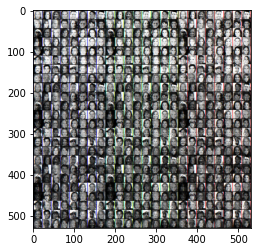

In [10]:
import matplotlib.pyplot as plt
plt.imshow(grid.cpu().reshape(530, 530, 3))

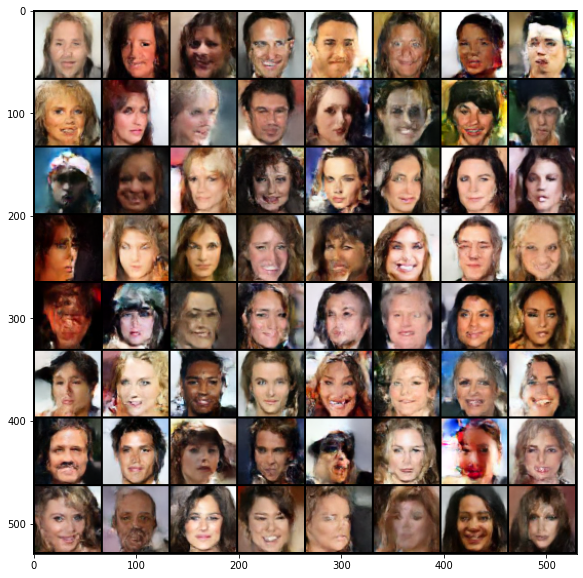

In [11]:
img = plt.imread(sample_path + image_name+'.png')
plt.figure(figsize=(10, 10))
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


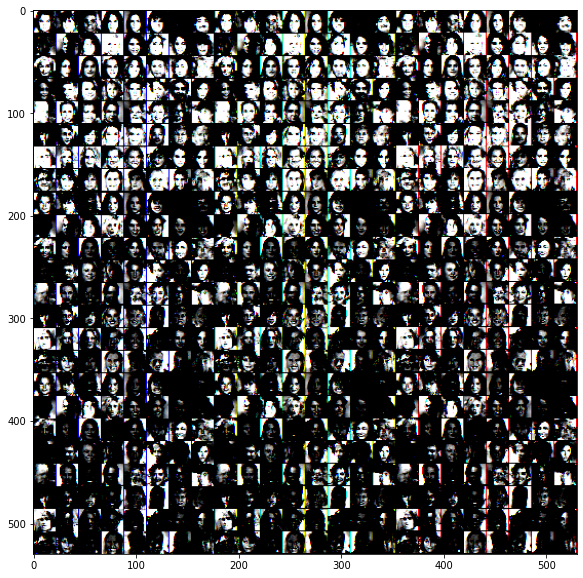

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
plt.imshow(grid.cpu().reshape(530, 530, 3))

In [ ]:
 samples = flow.sample(args.sample_size)
            samples, _ = data_utils.logit_transform(samples, reverse=True)
            utils.save_image(utils.make_grid(samples),
                sample_path + dataset + '/' + filename + '_ep%d.png' % epoch)